In [1]:
# For inline plotting
%matplotlib inline

# For auto reloading
%load_ext autoreload
%autoreload 2

# Experiments of MLP and its sparse variants


- Initial MLP
- MLP with BIBD
- Random sparse MLP

## A bit setup

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.3.1  Device: cuda


## `Mlp`, `BibdMlp`, `RandomSparseMlp` on the MNIST dataset

In [3]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [4]:
from models import Mlp, BibdMlp, RandomSparseMlp


input_dim = 28 * 28 * 1
output_dim = 10

model_list = []
if torch.cuda.is_available():
#     model_list.append(torch.nn.DataParallel(Mlp(input_dim, output_dim).to(device)))
#     model_list.append(torch.nn.DataParallel(BibdMlp(input_dim, output_dim).to(device)))
#     model_list.append(torch.nn.DataParallel(RandomSparseMlp(input_dim, output_dim).to(device)))
    model_list.append(Mlp(input_dim, output_dim).to(device))
    model_list.append(BibdMlp(input_dim, output_dim).to(device))
    model_list.append(RandomSparseMlp(input_dim, output_dim).to(device))
for model in model_list:
    print(model)

Mlp(
  (fc1): Linear(in_features=784, out_features=112, bias=True)
  (fc2): Linear(in_features=112, out_features=56, bias=True)
  (fc3): Linear(in_features=56, out_features=10, bias=True)
)
BibdMlp(
  (bibd1): BibdLinear()
  (bibd2): BibdLinear()
  (fc3): Linear(in_features=56, out_features=10, bias=True)
)
RandomSparseMlp(
  (randomSparseLinear1): RandomSparseLinear()
  (randomSparseLinear2): RandomSparseLinear()
  (fc3): Linear(in_features=56, out_features=10, bias=True)
)


In [5]:
%%time


from experiment import Experiment


experiment = Experiment(n_epoch=10)
for model in model_list:
    experiment.run_model(model, train_loader, validation_loader)

Using PyTorch version: 1.3.1  Device: cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315427
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.780750
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.316878
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.530546

Validation set: Average loss: 0.3299, Accuracy: 9026/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.495380
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.269123
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.449850
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.338651

Validation set: Average loss: 0.2638, Accuracy: 9236/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.381244
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.502382
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.063787
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.102173

Validation set: Average loss: 0.2064, Accuracy: 9392/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.140514
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.300824
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.101157
Train Epoch: 4 [48000/6000

### Plot training loss and test accuracy v.s. epoch

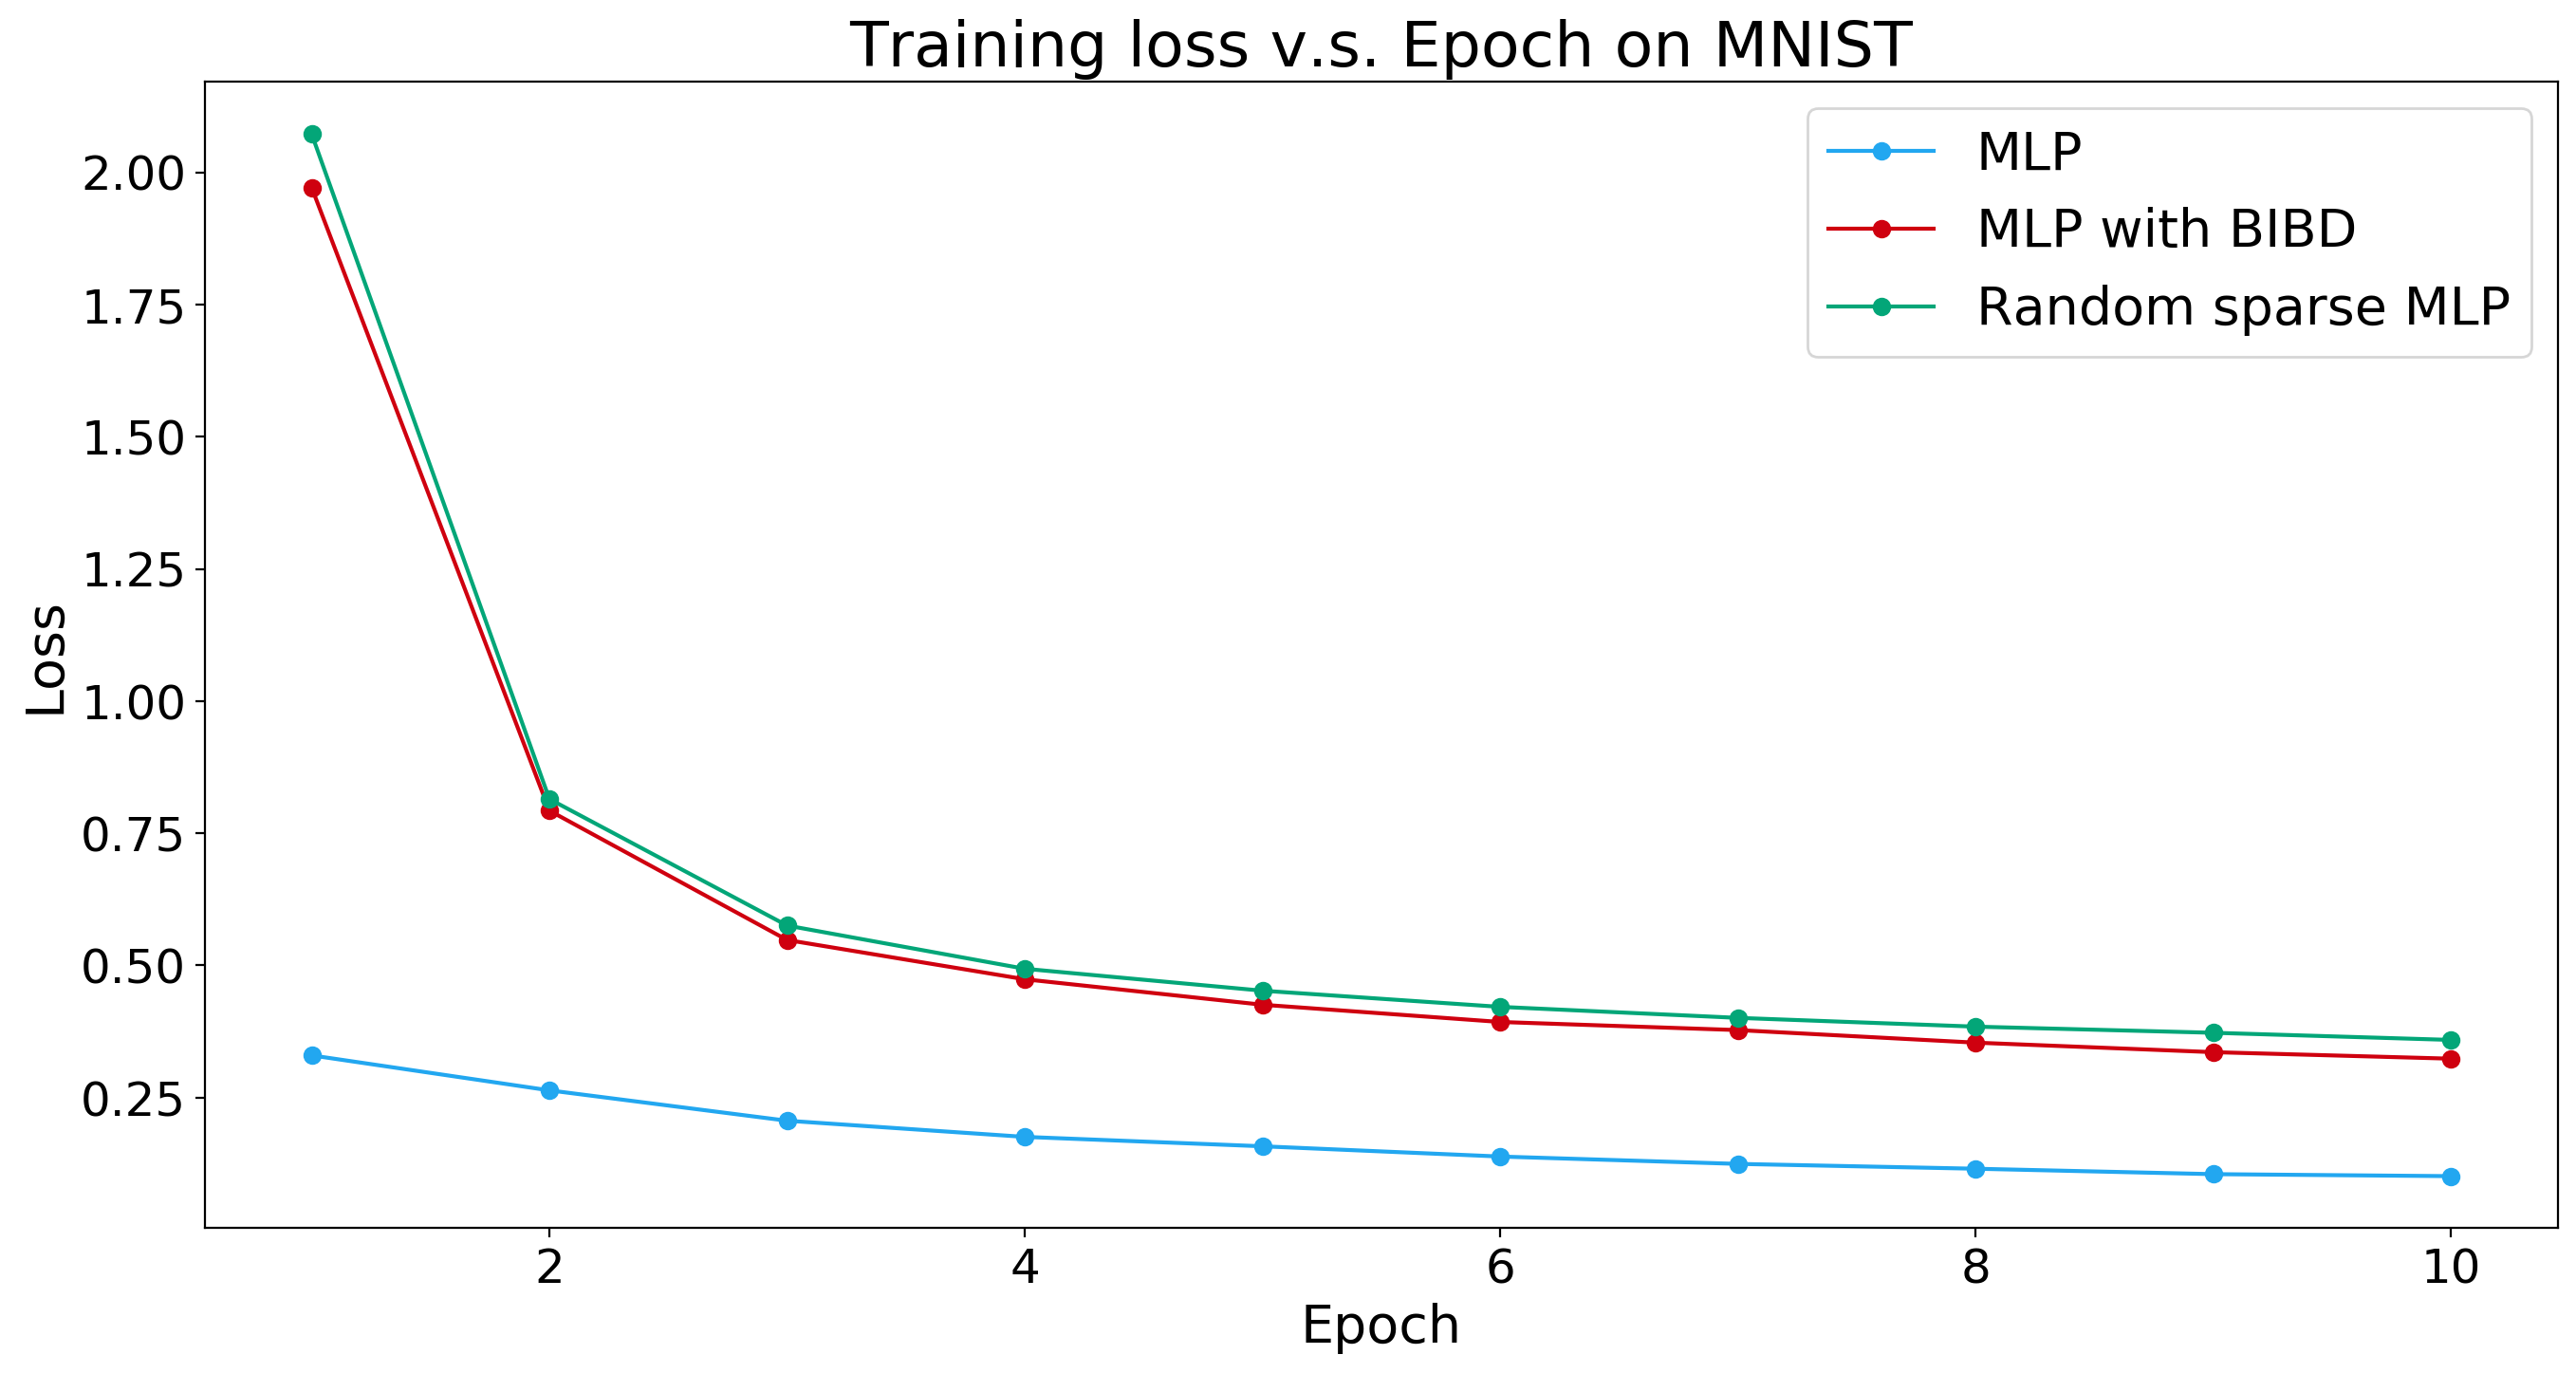

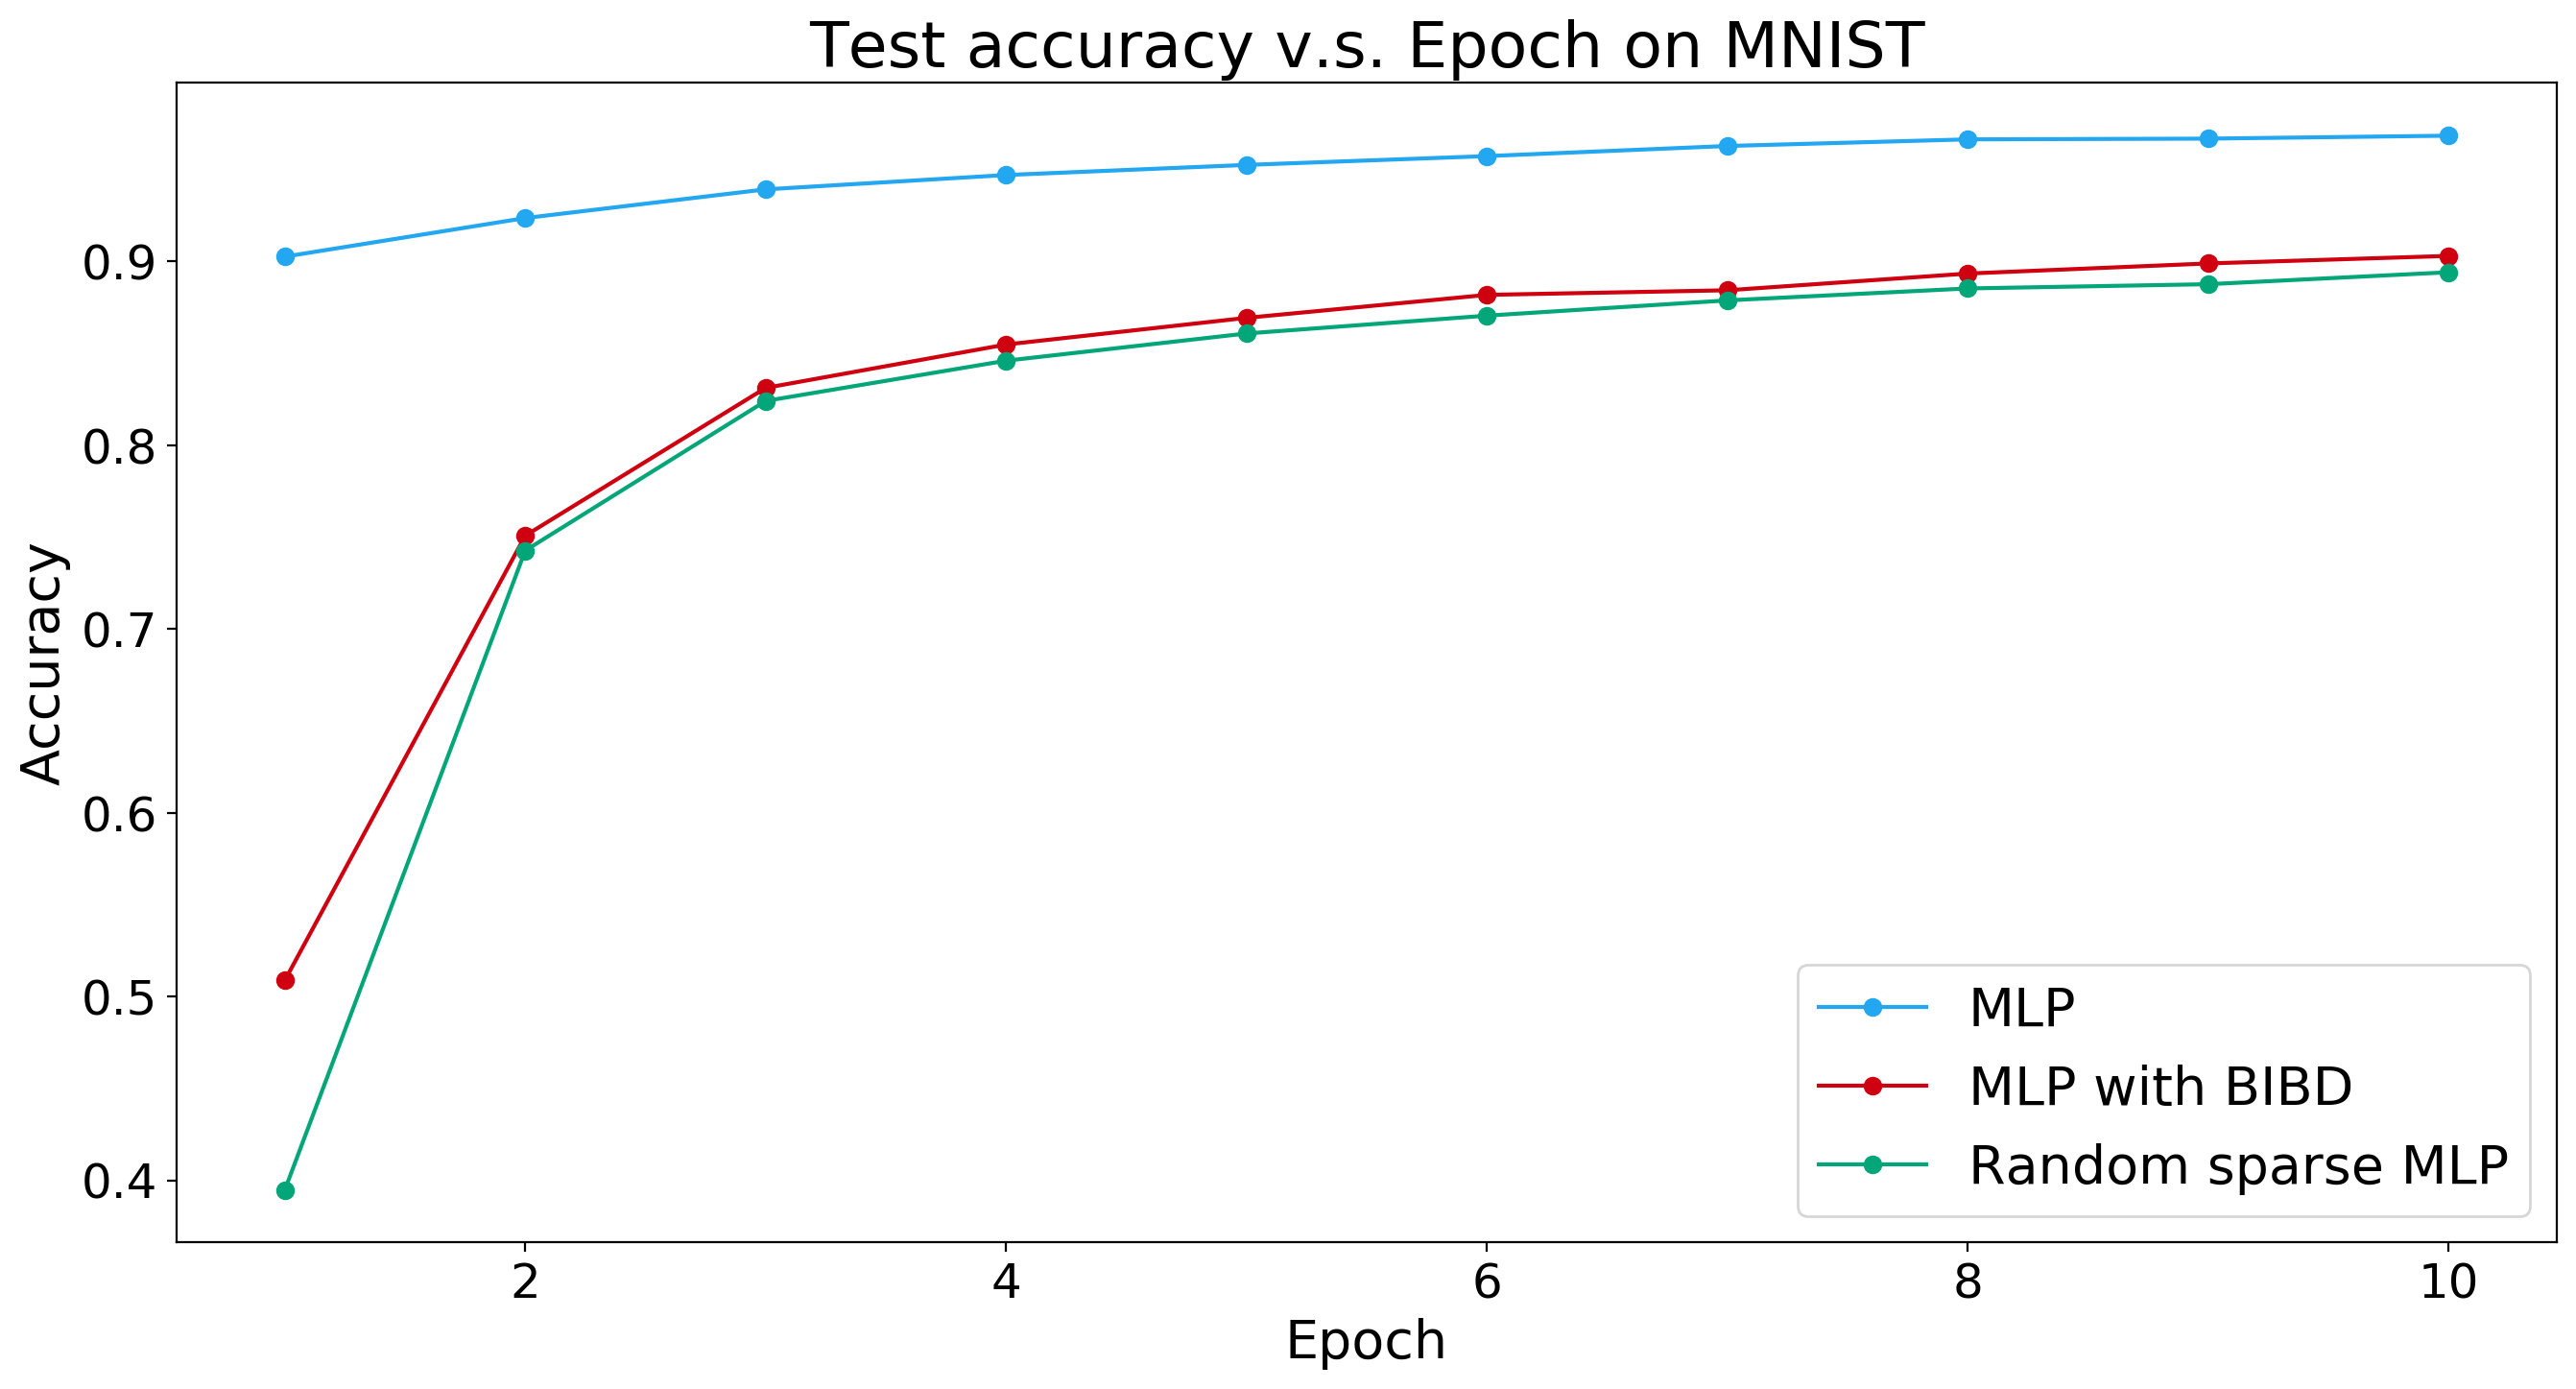

In [6]:
fig_loss, fig_acc = experiment.plot(loss_title='Training loss v.s. Epoch on MNIST', acc_title='Test accuracy v.s. Epoch on MNIST')

### Save the plots

In [7]:
import matplotlib.pyplot as plt


fig_loss.set_size_inches((16, 12))
fig_loss.set_dpi(100)
fig_acc.set_size_inches((16, 12))
fig_acc.set_dpi(100)

# plt.tight_layout()

fig_loss.savefig('fig_loss_mnist.eps', format='eps', pad_inches=0)
fig_acc.savefig('fig_acc_mnist.eps', format='eps', pad_inches=0)

# fig_loss.savefig('fig_loss.svg', format='svg', pad_inches=0)

# fig_loss.savefig('fig_loss.png', format='png', pad_inches=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## `Mlp`, `BibdMlp` and `RandomSparseMlp` on the CIFAR10 dataset

In [3]:
batch_size = 32

train_dataset = datasets.CIFAR10('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.CIFAR10('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

Files already downloaded and verified


In [4]:
from models import Mlp, BibdMlp, RandomSparseMlp


input_dim = 32 * 32 * 3
output_dim = 10

model_list = []
if torch.cuda.is_available():
#     model_list.append(torch.nn.DataParallel(Mlp(input_dim, output_dim).to(device)))
#     model_list.append(torch.nn.DataParallel(BibdMlp(input_dim, output_dim).to(device)))
#     model_list.append(torch.nn.DataParallel(RandomSparseMlp(input_dim, output_dim).to(device)))
    model_list.append(Mlp(input_dim, output_dim).to(device))
    model_list.append(BibdMlp(input_dim, output_dim).to(device))
    model_list.append(RandomSparseMlp(input_dim, output_dim).to(device))
for model in model_list:
    print(model)

Mlp(
  (fc1): Linear(in_features=3072, out_features=112, bias=True)
  (fc2): Linear(in_features=112, out_features=56, bias=True)
  (fc3): Linear(in_features=56, out_features=10, bias=True)
)
BibdMlp(
  (bibd1): BibdLinear()
  (bibd2): BibdLinear()
  (fc3): Linear(in_features=56, out_features=10, bias=True)
)
RandomSparseMlp(
  (randomSparseLinear1): RandomSparseLinear()
  (randomSparseLinear2): RandomSparseLinear()
  (fc3): Linear(in_features=56, out_features=10, bias=True)
)


In [5]:
%%time


from experiment import Experiment


experiment = Experiment(n_epoch=10)
for model in model_list:
    experiment.run_model(model, train_loader, validation_loader)

Using PyTorch version: 1.3.1  Device: cuda
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303931
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.264081
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.869437
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.782186

Validation set: Average loss: 1.8128, Accuracy: 3444/10000 (34%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.801881
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.765490
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.761239
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.625405

Validation set: Average loss: 1.7062, Accuracy: 3879/10000 (39%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.654598
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.598524
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.740399
Train Epoch: 3 [48000/50000 (96%)]	Loss: 1.706052

Validation set: Average loss: 1.6261, Accuracy: 4175/10000 (42%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.418422
Train Epoch: 4 [16000/50000 (32%)]	Loss: 1.608714
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.748195
Train Epoch: 4 [48000/5000

### Plot training loss and test accuracy v.s. epoch

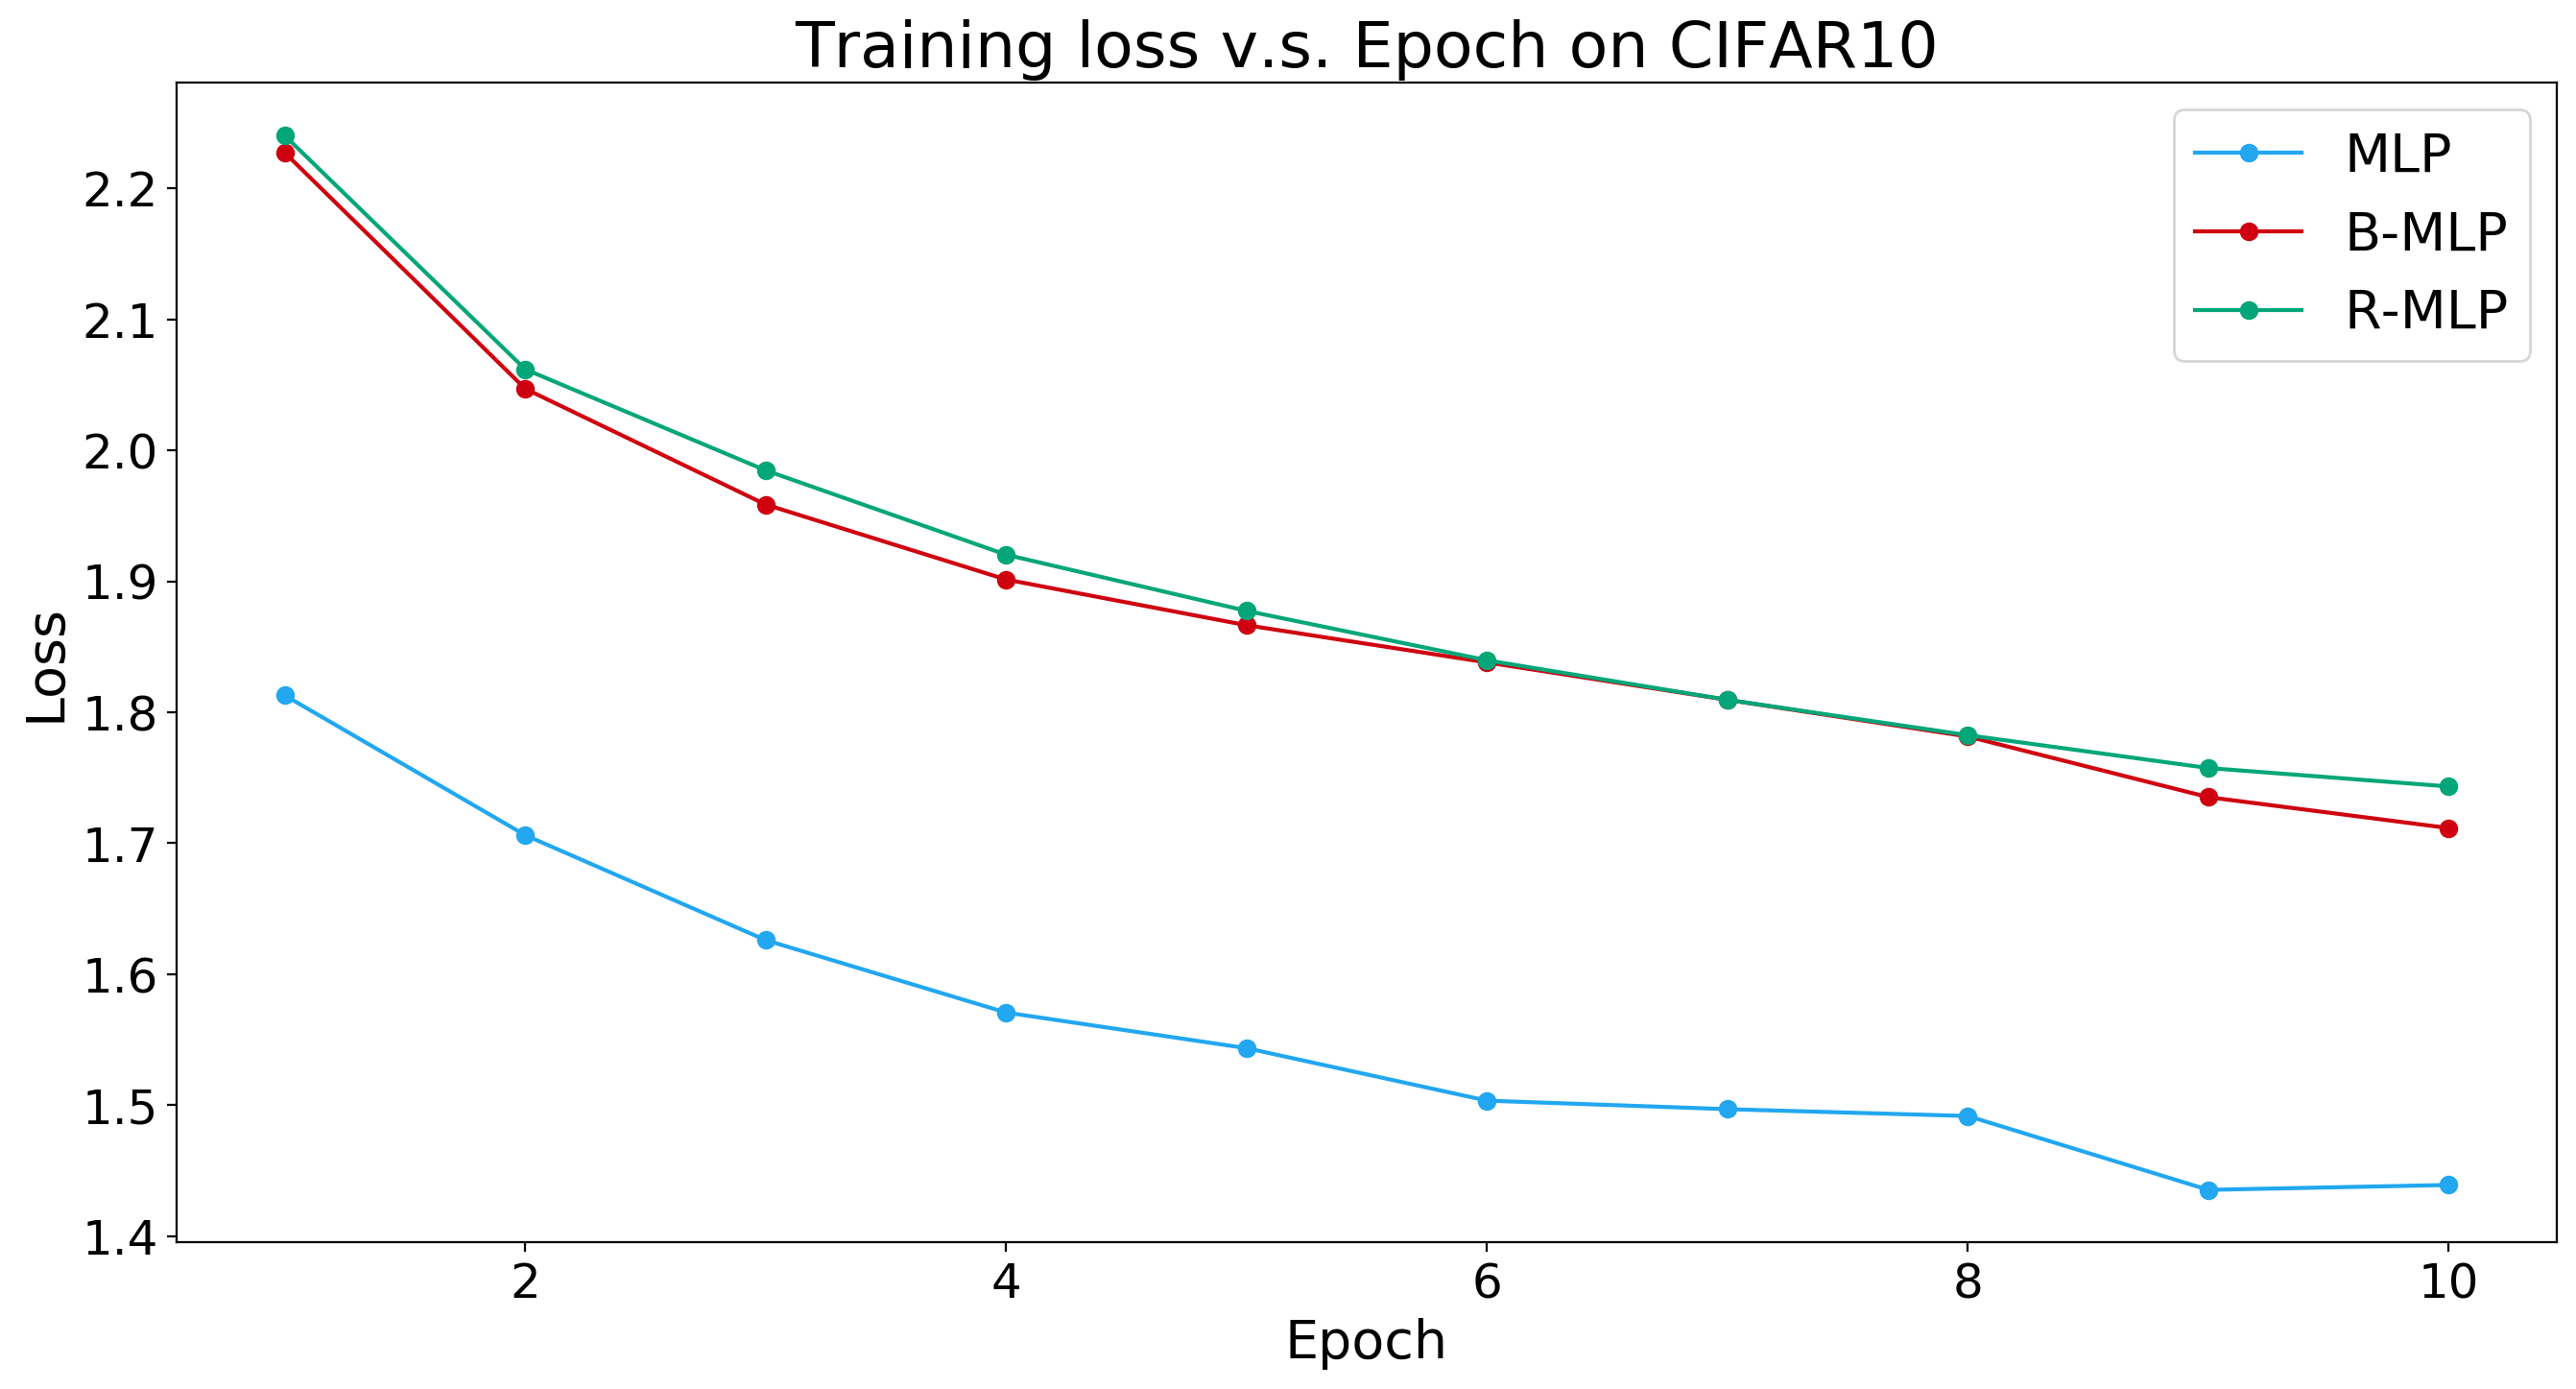

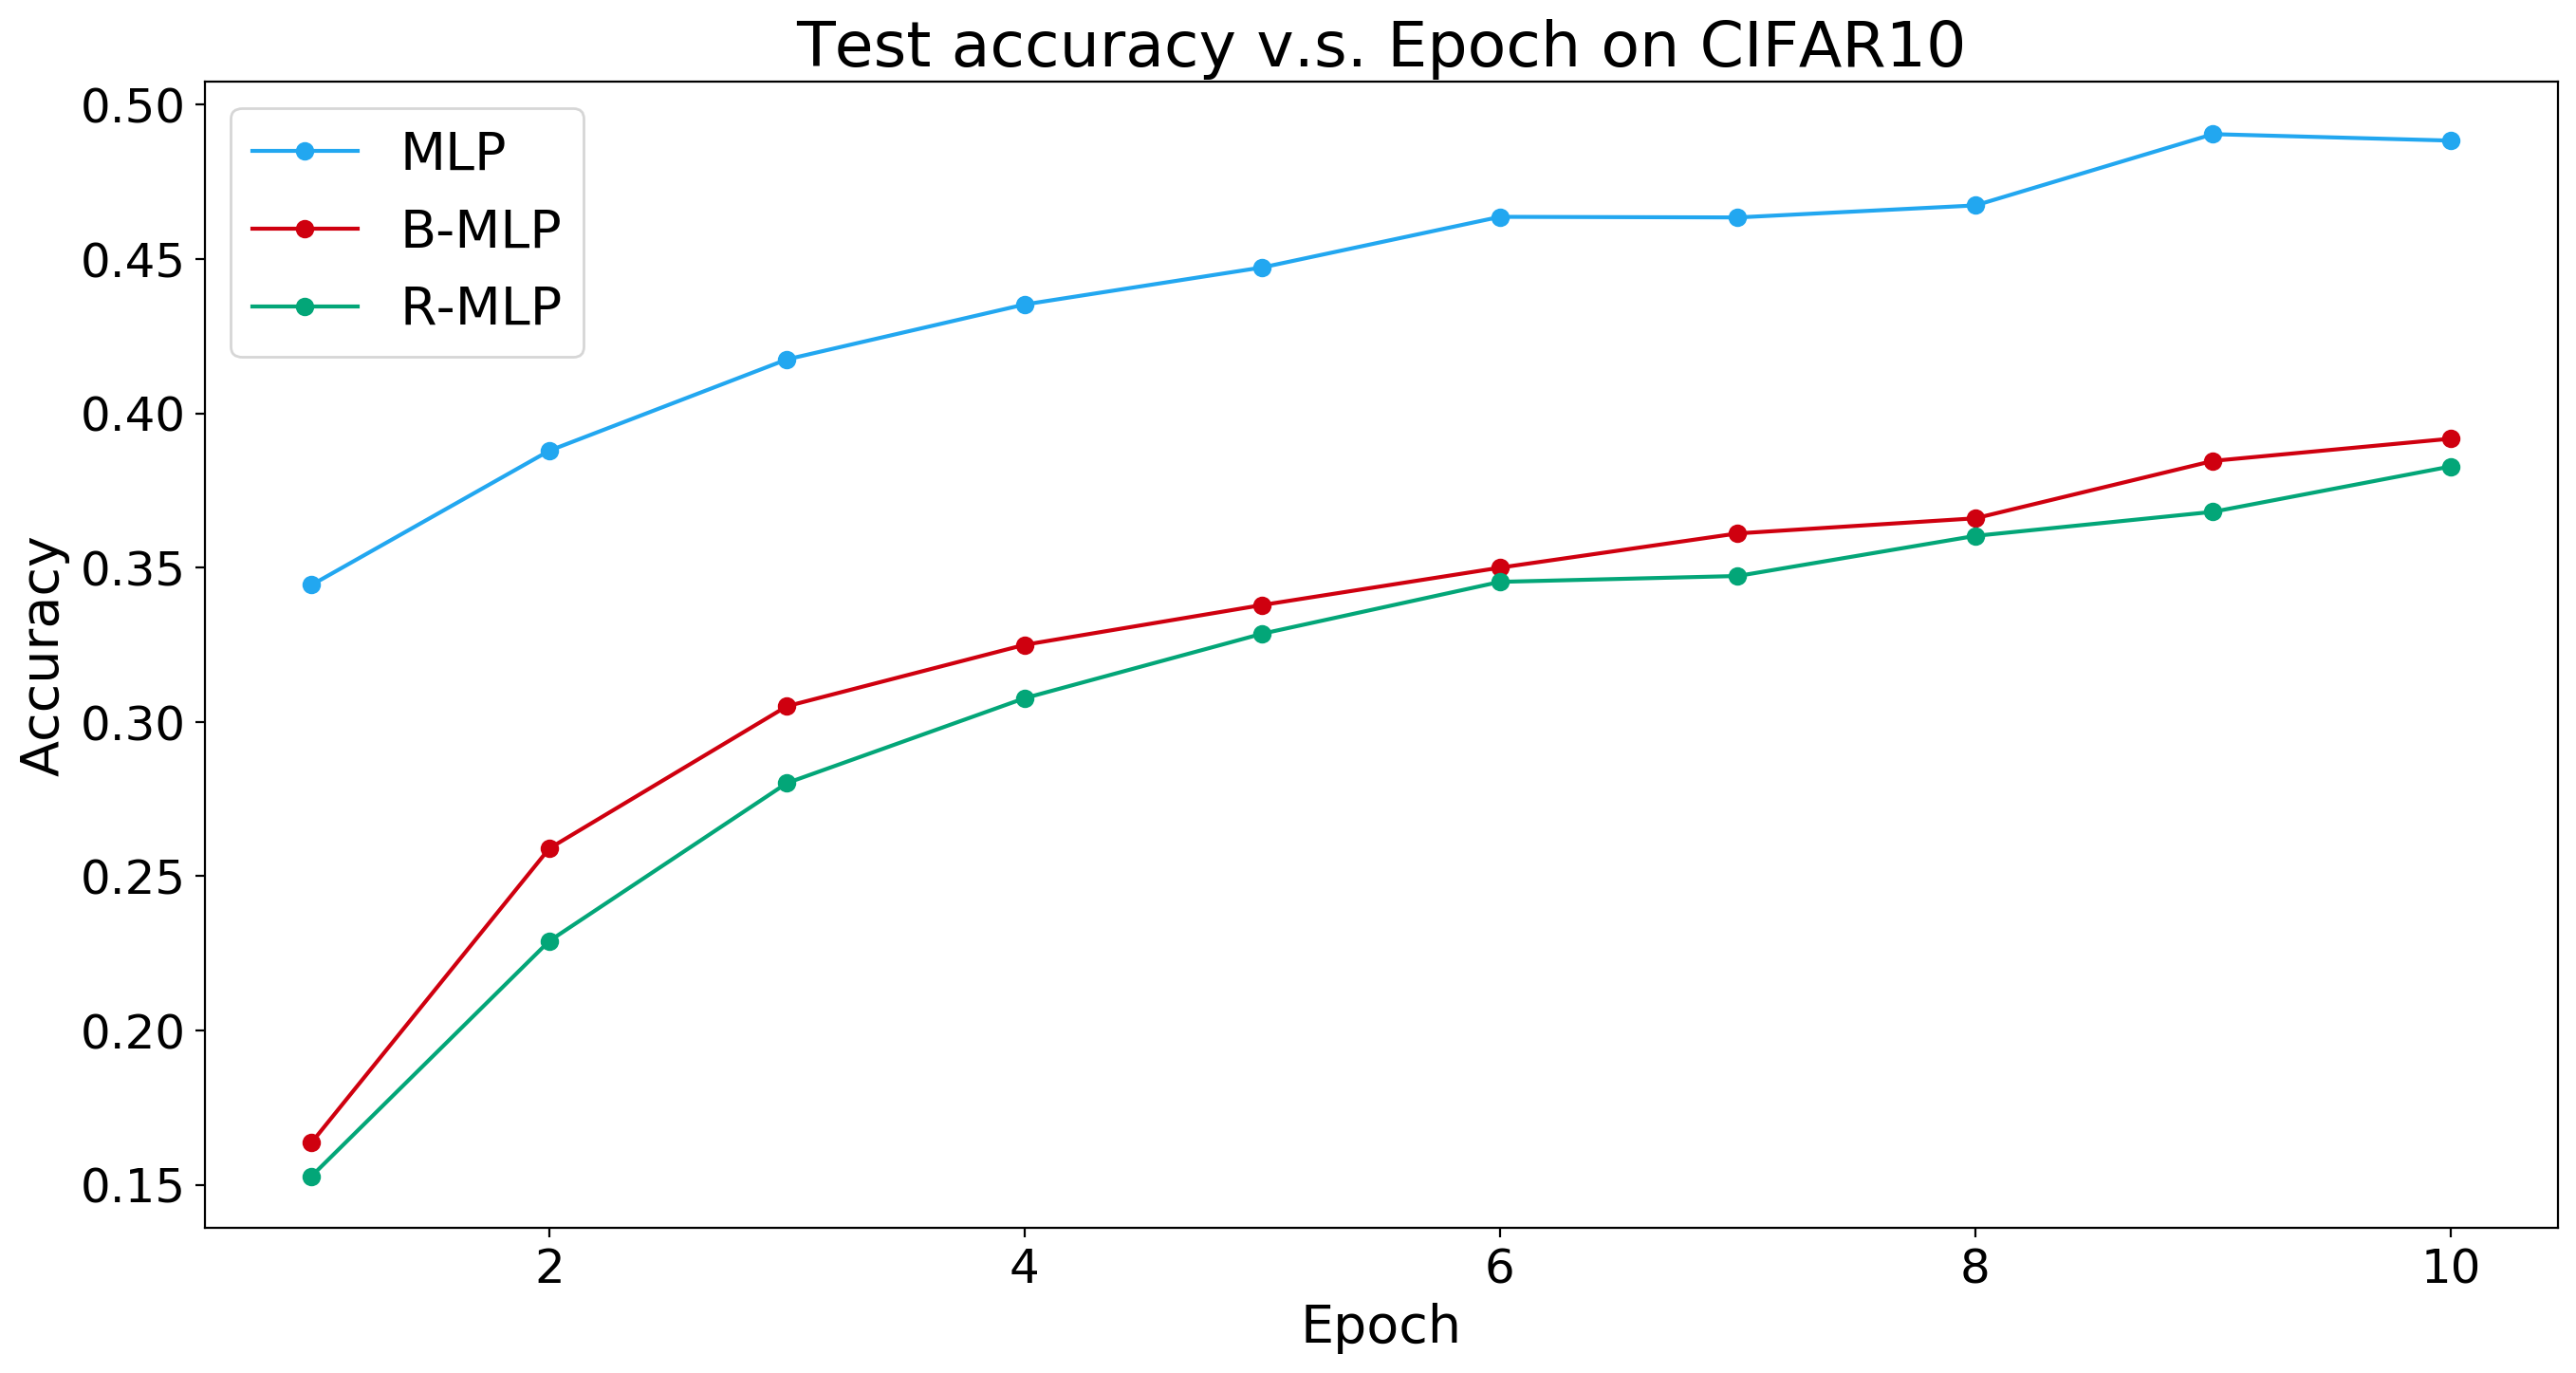

In [6]:
fig_loss, fig_acc = experiment.plot(loss_title='Training loss v.s. Epoch on CIFAR10', acc_title='Test accuracy v.s. Epoch on CIFAR10')